# **Supervised Learning**

In this notebook, I will apply Supervised Learning (Classification) on a Credit Craud Fraud Detection Dataset.

### Objective

To implement a cost-sensitive Gradient Boosting (XGBoost) classifier to accurately detect fraudulent transactions and overcome the extreme challenge of class imbalance.

In [50]:
# !wget https://pandio-com.github.io/static/files/datasets/creditcardfraud.zip
# !unzip creditcardfraud.zip
# !rm creditcardfraud.zip

## Exploratory Data Analysis (EDA)

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
df = pd.read_csv('creditcard.csv')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [54]:
df[['Time', 'Amount', 'Class']].describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


In [55]:
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


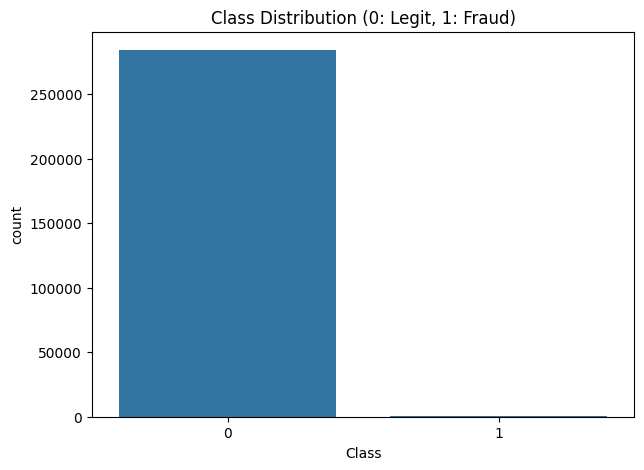

In [56]:
plt.figure(figsize=(7,5))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Legit, 1: Fraud)')
plt.show()

In [57]:
fraud_pct = (df['Class'].value_counts()[1] / len(df)) * 100
print(f"Percentage of Fraud Transactions: {fraud_pct:.3f}%")

Percentage of Fraud Transactions: 0.173%


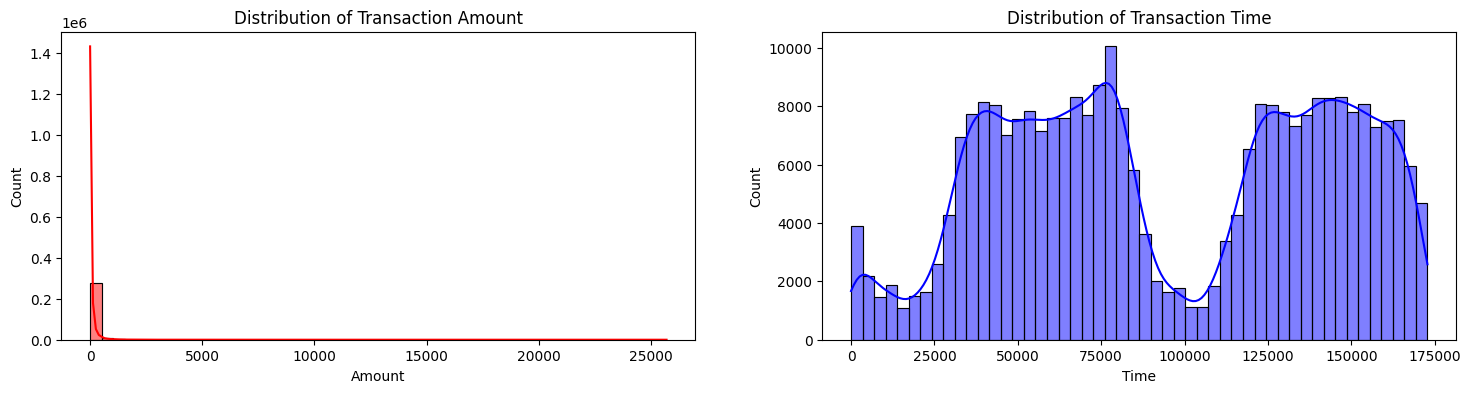

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(df['Amount'], bins=50, kde=True, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount')

sns.histplot(df['Time'], bins=50, kde=True, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time')

plt.show()

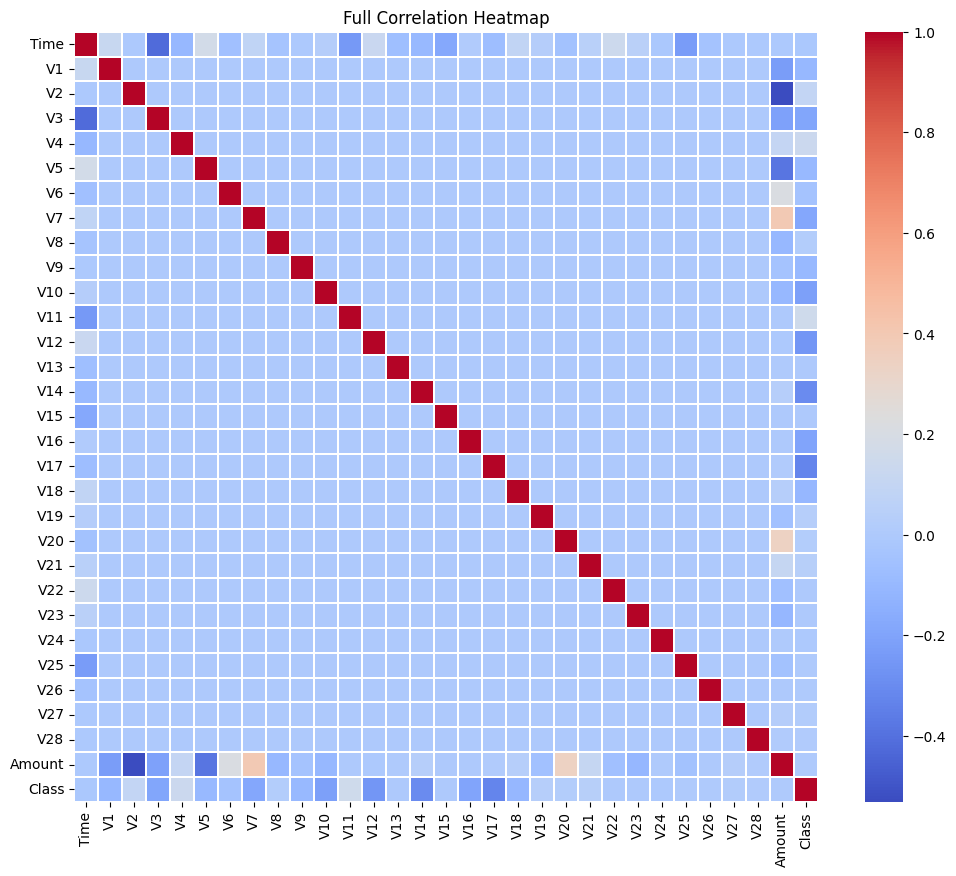

In [59]:
corr = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths=0.1)
plt.title('Full Correlation Heatmap')
plt.show()

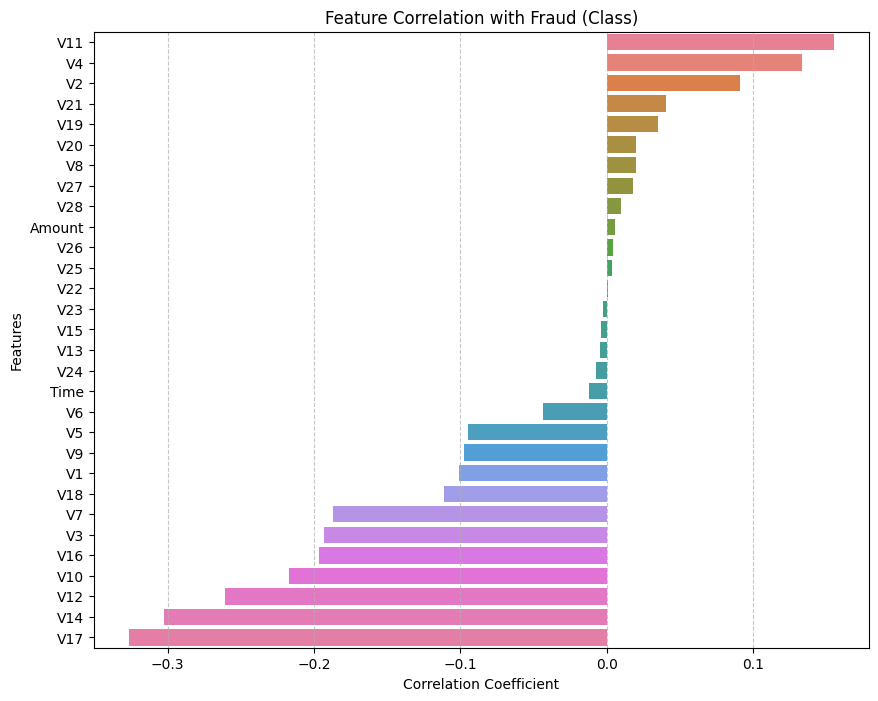

In [60]:
class_corr = df.corr()['Class'].drop('Class').sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=class_corr.values, y=class_corr.index, hue=class_corr.index, legend=False)
plt.title('Feature Correlation with Fraud (Class)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Data Preprocessing

In [61]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

print(df.columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'scaled_amount', 'scaled_time'],
      dtype='object')


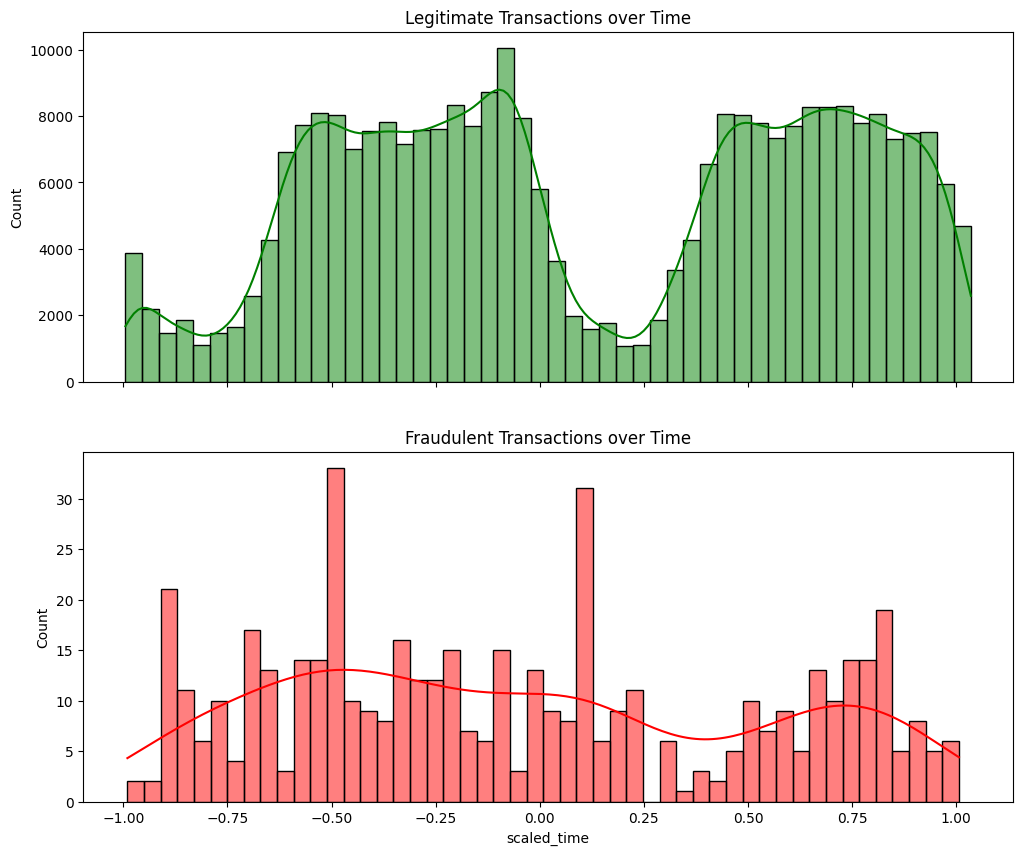

In [62]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.histplot(df[df['Class'] == 0]['scaled_time'], bins=50, ax=ax[0], color='g', kde=True)
ax[0].set_title('Legitimate Transactions over Time')

sns.histplot(df[df['Class'] == 1]['scaled_time'], bins=50, ax=ax[1], color='r', kde=True)
ax[1].set_title('Fraudulent Transactions over Time')

plt.show()

## Handling Class Imbalance

In [63]:
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Original Fraud cases in Train: {sum(y_train == 1)}")
print(f"Original Fraud cases in Test: {sum(y_test == 1)}")

Original Fraud cases in Train: 394
Original Fraud cases in Test: 98


In [64]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Fraud cases after SMOTE: {sum(y_train_res == 1)}")
print(f"Legit cases after SMOTE: {sum(y_train_res == 0)}")

Fraud cases after SMOTE: 227451
Legit cases after SMOTE: 227451


## Model Training and Evaluation

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_res, y_train_res)

y_pred = log_reg.predict(X_test)

In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



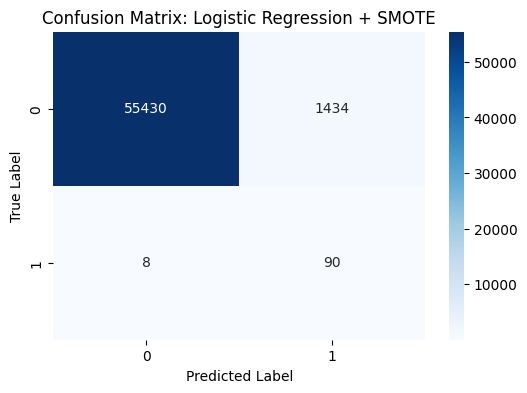

In [74]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Logistic Regression + SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [68]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
rf_model.fit(X_train_res, y_train_res)

y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.51      0.85      0.63        98

    accuracy                           1.00     56962
   macro avg       0.75      0.92      0.82     56962
weighted avg       1.00      1.00      1.00     56962



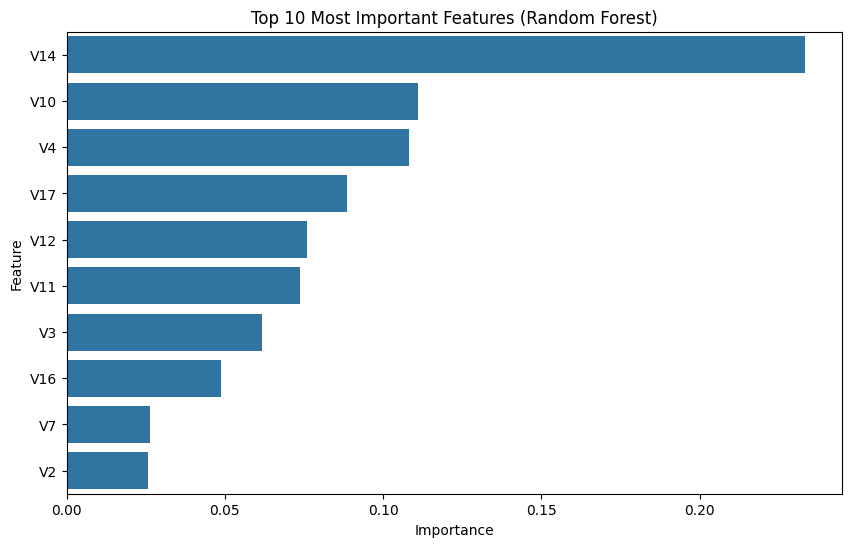

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Most Important Features (Random Forest)')
plt.show()

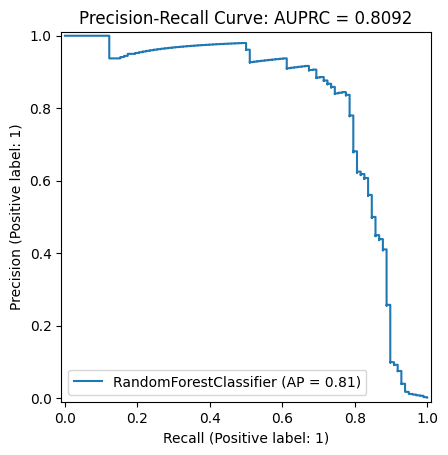

In [70]:
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_score = rf_model.predict_proba(X_test)[:, 1]
auprc_score = average_precision_score(y_test, y_score)

display = PrecisionRecallDisplay.from_estimator(rf_model, X_test, y_test)
display.ax_.set_title(f"Precision-Recall Curve: AUPRC = {auprc_score:.4f}")
plt.show()

In [71]:
from xgboost import XGBClassifier

weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(scale_pos_weight=weight, n_estimators=100, random_state=42)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



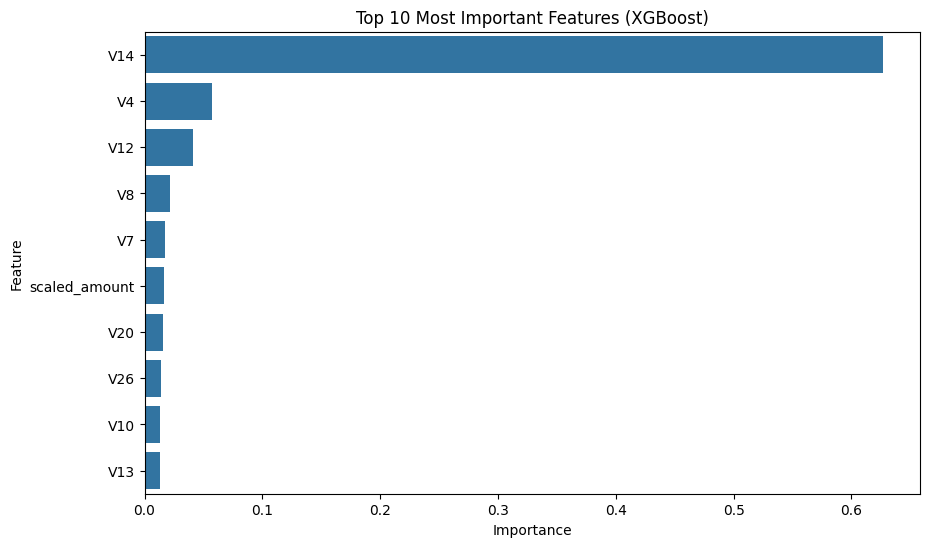

In [72]:
feature_importances = xgb.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Most Important Features (XGBoost)')
plt.show()

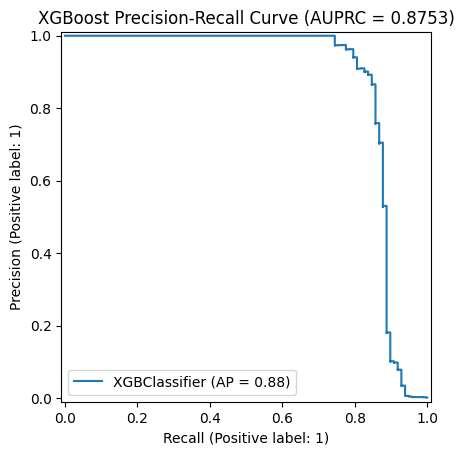

In [73]:
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay

y_score_xgb = xgb.predict_proba(X_test)[:, 1]
auprc_score_xgb = average_precision_score(y_test, y_score_xgb)

display = PrecisionRecallDisplay.from_estimator(xgb, X_test, y_test)
display.ax_.set_title(f"XGBoost Precision-Recall Curve (AUPRC = {auprc_score_xgb:.4f})")
plt.show()